In [1]:
!pip install graphlearning
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets
import scipy
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 6.3 MB/s 
  Created wheel for graphlearning: filename=graphlearning-1.2.1-cp37-cp37m-linux_x86_64.whl size=144133 sha256=a82ef53b133c140039be0256001ae79e08c1bb8a0d5da0d680120d782d4d7059
  Stored in directory: /root/.cache/pip/wheels/6a/c1/4e/28764782941c598ef87452db831616333364fabab44bdf749d
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=ecfeb78e4a23c1e359910ce87370ed573d27cf8167c25b9e7e2adae0ab57fe81
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built graphlearning sklearn


# Cheat Sheet
$$ \phi: X \to \mathbb{R^k},\quad \nabla \phi: X^2 \to \mathbb{R^k},\quad \nabla \phi(x_i, x_j) = \phi(x_j) - \phi(x_i) $$
$$ V: X^2 \to \mathbb{R^k},\quad \text{div}V: X \to \mathbb{R^k},\quad \text{div}V(x_i) = \sum_{i,j} w_{i,j}V(x_i, x_j) $$

## Algorithm
Approximate the Kantorovich potential $\phi:X \to \mathbb{R^k}$ of by some sequence $\phi^n$.

Initialize $\phi^0 \in l_2(X), V^0 \in l_2(X^2), \sigma, \tau > 0$.
$$V^{n+1} = (I + \sigma \partial F^*)^{-1}(V^n + \sigma \nabla \phi^n) = \begin{cases}
\frac{|V^n + \sigma \nabla \phi^n| - \sigma}{|V^n + \sigma \nabla \phi^n|}(V^n + \sigma \nabla \phi^n), &\text{ when }  |V^n + \sigma \nabla \phi^n| > \sigma \\
0, &\text{ else}
\end{cases}$$
$$ \phi^{n+1} = (I + \tau \partial G)^{-1}(\phi^n - \tau \text{div} V^{n+1}) = \tau \mu + \phi^n - \tau \text{div}V^{n+1} $$

In [143]:
## Constants
# N = 10
# k = 2
# tau = 0.01
# sigma = 0.01
# np.random.seed(1)

# u_0 = np.random.randint(low = 0, high = 20, size=(N,k))

# # Generate training data and label sets
# X,labels = datasets.make_moons(n_samples=N,noise=0.1, random_state = 0)
# W = gl.weightmatrix.knn(X,5).toarray()

###########

"""
Computes the gradient of u
u: (n,k) matrix

Returns:
gradu: (n, n, k)

where gradu[i, j, l] = u[j,l]-u[i,l]
"""
def graph_grad(u):
    gradu = -u[:, np.newaxis] + u

    return gradu

# # Example:
# u = np.arange(6).reshape(3,2)
# print("u is\n", u)
# print("\nAnd gradu is")
# for i in range(u.shape[0]):
#     for j in range(u.shape[1]):
#         print(graph_grad(u)[i,j], end = "\t\t")
#     print()

"""
Computes the divergence of a vector field V
V: (n, n, k) matrix

Returns:
gradu: (n, n, k)

where gradu[i, j, l] = u[j,l]-u[i,l]
"""
def graph_div(V, W):
    n = V.shape[0]
    k = V.shape[2]
    div = ( V * (W[:, :, np.newaxis] + np.zeros((n,n,k))) ).sum(axis = 1)
    return div

# ### Example
# n = 3
# k = 4

# V = np.arange(n*n*k).reshape(n, n, k)
# W = np.arange(1, n * n + 1).reshape(n,n) % 3
# #print(V)
# #print(W)
# manual_div = np.zeros((n, k))
# for i in range(n):
#     for j in range(n):
#         manual_div[i] += W[i,j] * V[i, j]
# print(np.array_equal(graph_div(V, W), manual_div))

"""
Returns the labels that u predicts
"""
def predict(u):
    return np.argmax(u, axis = -1)

# def proxF(V):
#     VV = np.zeros(V.shape)
#     for i in range(V.shape[0]):
#             for j in range(V.shape[1]):
#                 tmp_norm = np.linalg.norm(V[i,j])
#                 if tmp_norm > sigma:
#                     VV[i,j] = (tmp_norm - sigma)/tmp_norm * V[i,j]
#     return VV

def proxF(V):
    VV = np.zeros(V.shape)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            VV[i,j] = fast_minimize_f(1/(2*sigma), V[i,j])

    return VV

def proxG(u):
    return tau * mu + u    

"""
Calculate the inner product of functions or vector fields
"""
def inner_product(x, y):
    if x.ndim == 2:
        return (x * y).sum()
    if x.ndim == 3:
        xx = (W[:, :, np.newaxis] + np.zeros((x.shape[0], x.shape[0], x.shape[2]))) * x
        return 0.5 * (xx*y).sum()

def slow_proxF_energy(U_flattened, V):
    U = U_flattened.reshape(V.shape)
    A = 0
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            A += 0.5 * W[i,j] * (1/(2*sigma) * np.linalg.norm(U[i,j] -V[i,j])**2 + np.linalg.norm(U[i,j]))

    return A
    # A = inner_product(U - V, U - V) / (2 * sigma)
    # B = 0.5 * (W * np.linalg.norm(U, axis = -1)).sum()
    # return A + B


def slow_proxF(Z):
    res = minimize(slow_proxF_energy, x0 = np.zeros((N, N, k)), args = (Z), method = 'CG')

    return res.x.reshape(Z.shape)     

# ##Example
# V = np.arange(2 * 2 * 3).reshape((2, 2,3))
# V = V - np.transpose(V, [1, 0, 2])
# VV = np.random.randint(low = 1, high = 3, size = (2,2,3))
# VV = VV - np.transpose(VV, [1, 0, 2])
# W = np.random.randint(low = -3, high = 3, size = (2,2))
# print("V = \n", V)
# print("VV = \n", VV)
# print("W = \n", W)
# print("product = \n", inner_product(V, VV))
# print("Energy = \n", slow_proxF_energy(VV.flatten(), V))

def toy_pd_solver(proxF, proxG, K = Id, K_dual = Id, theta = 1, threshold = 0.1e-10):
    max_steps = 10 ** 12
    difference = threshold + 1
    
    xx = np.zeros((N, k))
    x = np.zeros((N, k))
    x_bar = np.zeros((N, k))
    y = np.zeros((N,k))
    
    for i in range(max_steps):
        if difference < threshold:
            return xx
        yy = proxF(y + sigma * K(x_bar) )
        xx = proxG(x - tau * K_dual(yy))
        xx_bar = xx + theta * (xx - x)
        
        difference = np.linalg.norm(x - xx)
        
        x = xx
        y = yy
        x_bar = xx_bar
            
    print(i)
    return xx


def toy_proxF(u):
    N = u.shape[0]
    uu = np.zeros(u.shape)
    
    for i in range(N):
        norm = np.linalg.norm(u[i])
        if norm > 1:
            uu[i] = u[i]/norm
        else:
            uu[i] = u[i]
    
    return uu

###Example
# a = np.array([[1,1], [1,2]])
# print(a)
# print(toy_proxF(a))
# print(1/np.sqrt(2))

def toy_proxG(u):
    uu = np.zeros(u.shape)
    
    for i in range(u.shape[0]):
        uu[i] = (u[i] + 2 * tau * u_0[i])/(2 * tau + 1)
    
    return uu

def toy_energy(u_flattened):
    
    u = u_flattened.reshape(N, k)
    G = np.linalg.norm(u-u_0)**2
    F = np.linalg.norm(u, axis = 1).sum()
    
    return F + G
    
def toy_gradient_descent():
    res = minimize(toy_energy, x0 = np.zeros(N * k), method = 'trust-constr')
    u = res.x.reshape(N,k)
    
    return u

# ## Check on toy problem
# np.linalg.norm(toy_pd_solver(toy_proxF,toy_proxG )- toy_gradient_descent())

def f(x, a, c):
    norm_x = np.linalg.norm(x)

    return a * np.linalg.norm(x-c)**2 + np.linalg.norm(x)

def slow_minimize_f(a, c):
    n = c.shape[0]
    res = minimize(f, x0 = np.zeros(n), args = (a, c), method = 'trust-constr')

    return res.x

def fast_minimize_f(a, c):
    n = c.shape[0]
    norm_c = np.linalg.norm(c)
    
    if 2 * a * norm_c >= 1:
        return (2 * a * norm_c - 1)/(2 * a * norm_c) * c
    else:
        return 0

# alphas = [0, 0.01, 0.02, 0.03, 0.04, 0.05] + [i for i in range(1,20)]
# for a in alphas:
#     for c_1 in range(-50, 50, 10):
#         for c_2 in range(-50, 50,10):
#             c = np.array([c_1, c_2])
#             slow_minimum = slow_minimize_f(a, c)
#             fast_minimum = fast_minimize_f(a,c)
#             error = np.linalg.norm(slow_minimum - fast_minimum)
#             if error > 0.1 and f(slow_minimum, a, c) < f(fast_minimum, a, c):
#                 print(f"a = {a}, c = {c}, f(slow_minimum) - f(fast_minimum) = {f(slow_minimum, a, c) - f(fast_minimum, a, c)}, error = {error}")


# N = 10
# # k = 2
# # np.random.seed(1)
# # W = np.random.randint(low = 0, high = 20, size = (N, N))
# # W = W + W.T
# np.random.seed(9)
# V = np.random.randint(low = -10, high = 10, size = (N,N,k))
# V = V - np.transpose(V, [1, 0, 2])

# fast = proxF(V)
# slow = slow_proxF(V)
# print(np.linalg.norm(fast - slow))
# print(slow_proxF_energy(slow.flatten(), V) - slow_proxF_energy(fast.flatten(), V))

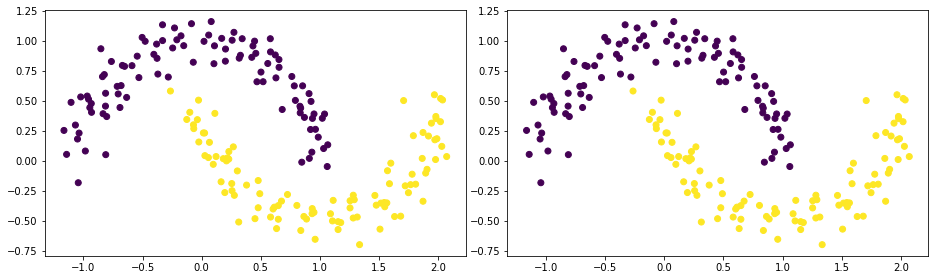

In [236]:
N = 200
k = 2

fig, ax = plt.subplots(ncols = 2, figsize = (13, 4))
fig.tight_layout()

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=N,noise=0.1, random_state = 0)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=10, seed = 0)
train_labels = labels[train_ind]
m = train_ind.size

# Construction of measure mu
# mu[i] = [0, 0] if i is  not in the training dataset
# mu[i] = [1,0] if i is in the training dataset and its label is 1
# mu[i] = [0,1] if i is in the training dataset and its label is 0

mean = np.array([5,5])/m
a_idx = train_ind[np.argwhere(labels[train_ind] == 1)].flatten()
b_idx = train_ind[np.argwhere(labels[train_ind] == 0)].flatten()
mu = np.zeros((N,k))
mu[a_idx] = [1,0] - mean
mu[b_idx] = [0,1] - mean

ax[0].scatter(X[:,0],X[:,1], c=labels)
ax[1].scatter(X[:,0],X[:,1], c=labels)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


[[-7.04970096e+02 -6.99970096e+02]
 [-7.12970096e+02 -7.13970095e+02]
 [-7.08970093e+02 -7.08970094e+02]
 [-6.97970097e+02 -6.98970096e+02]
 [-4.82911685e+03 -6.13365662e+03]
 [-7.10970096e+02 -6.97970095e+02]
 [-7.01970095e+02 -7.09970096e+02]
 [-7.11970092e+02 -7.10970095e+02]
 [-7.03970096e+02 -6.95970095e+02]
 [-7.05970096e+02 -7.06970095e+02]
 [-7.08970096e+02 -7.02970095e+02]
 [-7.01970094e+02 -7.08970096e+02]
 [-5.53440243e+03 -6.70755130e+02]
 [-5.52579444e+03 -6.71092552e+02]
 [-7.13970096e+02 -7.02970096e+02]
 [-6.96970096e+02 -7.04970094e+02]
 [-6.97970096e+02 -7.13970096e+02]
 [-7.09970096e+02 -7.00970095e+02]
 [-6.99970095e+02 -7.13970097e+02]
 [-7.09970096e+02 -7.13970096e+02]
 [-6.96970095e+02 -7.07970094e+02]
 [-6.95970093e+02 -7.04970094e+02]
 [-7.11970096e+02 -6.97970094e+02]
 [-7.03970092e+02 -7.05970094e+02]
 [-7.11970095e+02 -6.96970095e+02]
 [-6.95970094e+02 -7.00970092e+02]
 [-6.97970095e+02 -7.10970095e+02]
 [-6.98970096e+02 -7.09970096e+02]
 [-7.00970096e+02 -7

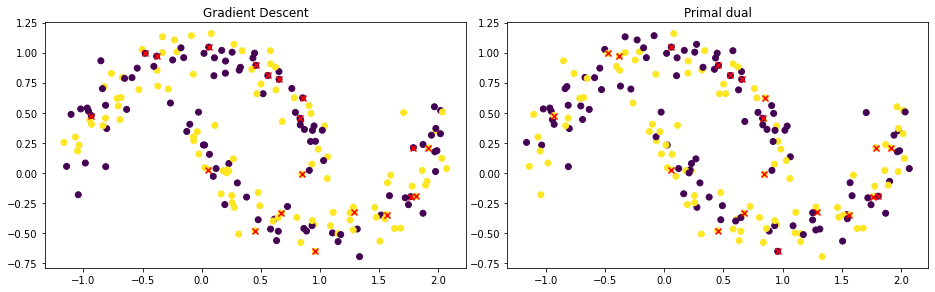

In [237]:
from scipy.optimize import NonlinearConstraint

def I(u_flattened):
    u = u_flattened.reshape(N, k)
    
    integral = (u * mu).sum()

    return -integral

def grad_sup(u_flattened):
    u = u_flattened.reshape(N, k)

    pairwise_differences = (u[:,np.newaxis] - u)
    max_abs = np.linalg.norm(pairwise_differences, axis = -1).max()
    
    return max_abs

def minimize_I():
    constr = NonlinearConstraint(grad_sup, -np.inf, 1)
    res = minimize(I, x0 = np.zeros(N*k), constraints = constr, method = 'trust-constr', hess = lambda x: np.zeros((N*k, N*k)))

    return res.x.reshape(N,k)


fig, ax = plt.subplots(ncols = 2, figsize = (13, 4))
fig.tight_layout()

u_grad_descent = -minimize_I()
u_primal_dual = pd_solver(proxF, proxG, W)
pred_grad_descent = predict(u_grad_descent)
pred_primal_dual = predict(u_primal_dual)

ax[0].scatter(X[:,0],X[:,1], c=pred_grad_descent)
ax[0].scatter(X[train_ind, 0], X[train_ind, 1], marker = 'x', c = 'red')
ax[0].set_title("Gradient Descent")

ax[1].scatter(X[:,0],X[:,1], c=pred_primal_dual)
ax[1].scatter(X[train_ind, 0], X[train_ind, 1], marker = 'x', c = 'red')
ax[1].set_title("Primal dual")

print(u_grad_descent - u_primal_dual)
print(np.linalg.norm(u_grad_descent - u_primal_dual))
print(np.count_nonzero(pred_grad_descent - pred_primal_dual))

plt.show()
# np.random.seed(1)
# u = np.random.randint(low = -10, high = 10, size = (N,k))
# print("u = \n", u)
# pairwise_differences = (u[:,np.newaxis] - u)
# max_abs = np.linalg.norm(pairwise_differences, axis = -1).max()

# max_abs_so_far = 0
# for i in range(N):
#     for j in range(N):
#         max_abs_so_far = max(np.linalg.norm(u[i] - u[j]), max_abs_so_far)
# print(max_abs_so_far, max_abs)
# print(np.linalg.norm(pairwise_differences[1,2]))
# np.linalg.norm(pairwise_differences, axis = -1)[1,2]
#pairwise_differences[i,j] = u[i] - u[j]

[[ 4.99999658  2.99999503]
 [16.99999745  3.999998  ]
 [ 2.99999618 10.99999647]
 [13.99999802 16.99999539]
 [ 7.99999602  9.99999643]
 [ 0.99999513 10.99999523]
 [18.9999975  11.99999523]
 [ 2.99999708  2.99999601]
 [ 3.99999767  3.99999539]
 [18.99999549 14.99999632]
 [ 3.99999694 17.99999664]
 [18.9999957  14.99999681]
 [ 9.99999704  1.99999652]
 [ 4.9999966  10.99999575]
 [11.99999701  8.99999694]
 [11.99999577  2.99999565]
 [16.99999664  0.99999558]
 [ 0.999996    6.99999692]
 [14.99999475 10.99999422]
 [ 8.99999585 13.99999556]
 [ 2.99999611  3.99999578]
 [ 2.99999824 11.99999634]
 [13.99999588 16.99999673]
 [ 8.99999525  8.99999674]
 [ 8.99999694  2.9999957 ]
 [ 3.99999616 12.99999656]
 [14.99999669  0.99999747]
 [ 4.99999779  3.99999712]
 [13.99999636 11.99999632]
 [13.99999729 13.99999611]
 [11.99999612 16.99999695]
 [14.99999679 16.99999762]
 [ 1.99999517  8.99999635]
 [ 0.9999949   4.99999729]
 [ 6.99999565 13.99999719]
 [ 7.99999619 15.9999962 ]
 [ 9.999997   18.99999647]
 

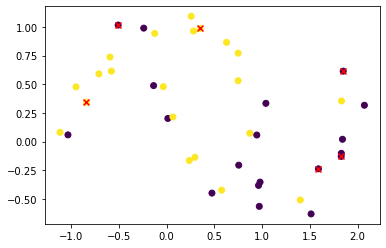

In [217]:
sigma = 1e-7
tau = 1e-7

def pd_solver(proxF, proxG, W, theta = 1, threshold = 1e-4):
    max_steps = 10 ** 5
    difference = threshold + 1
    
    xx = np.random.randint(low = 1, high = 20, size = (N, k))
    x = np.random.randint(low = 1, high = 20, size = (N, k))
    x_bar = np.random.randint(low = 1, high = 20, size = (N, k))
    y = np.random.randint(low = 1, high = 20, size = (N, N, k))
    yy = np.random.randint(low = 1, high = 20, size = (N, N, k))

    for i in range(max_steps):
        if difference < threshold:
            return xx
        # print(x.shape, xx.shape, y.shape, yy.shape)
        yy = proxF(y + sigma * graph_grad(x_bar) )
        xx = proxG(x - tau * graph_div(yy, W))
        xx_bar = xx + theta * (xx - x)
        
        difference = np.linalg.norm(x - xx)
        
        x = xx
        y = yy
        x_bar = xx_bar
            
    print("Reached maximum steps")
    return xx

u = pd_solver(proxF, proxG, W)
print(u)
predictions = predict(u)
plt.scatter(X[:,0],X[:,1], c=predictions)
plt.scatter(X[train_ind, 0], X[train_ind, 1], marker = 'x', c = 'red')